<center>
<img src="../../img/ods_stickers.jpg">
## Open Data Science course. Session № 2
</center>
Authors: Olga Daikhovskaya, Yury Kashnitsky. The material is distributed under [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). You are free to use the material for any non-commercial purposes, mentioning the original authors is mandatory.

# <center>Homework № 7.
## <center> Unupervised learning

In this task, we will look at how data dimensionality reduction and clustering methods work. At the same time, we'll practice solving classification task again.

We will work with the [Samsung Human Activity Recognition] (https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. Download the data from there. The data comes from the accelerometers and gyros of Samsung Galaxy S3 mobile phones ( you can find more info about the features using on the link above), the type of activity of a person with a phone in his pocket is also known - whether he walked, stood, lay, sat or walked up or down the stairs.

First we imagine that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. Then we solve the problem of determining the type of physical activity precisely as a classification problem.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


# BB added this option
from sklearn.metrics.cluster import adjusted_rand_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("HAPT Data Set/Train/X_train.txt")
y_train = np.loadtxt("HAPT Data Set/Train/y_train.txt").astype(int)

X_test = np.loadtxt("HAPT Data Set/Test/X_test.txt")
y_test = np.loadtxt("HAPT Data Set/Test/y_test.txt").astype(int)

In [4]:
# Checking the data
print("X_train contains: ")
X_train
X_train.shape

print("y_train contains: ")
y_train
y_train.shape

print("X_test contains: ")
X_test
X_test.shape

print("y_test contains: ")
y_test
y_test.shape

X_train contains: 


array([[ 0.04357967, -0.00597022, -0.03505434, ..., -0.84155851,
         0.17991281, -0.05171842],
       [ 0.03948004, -0.00213128, -0.02906736, ..., -0.8450924 ,
         0.18026111, -0.04743634],
       [ 0.03997778, -0.00515272, -0.02265071, ..., -0.84923013,
         0.18060956, -0.04227136],
       ...,
       [ 0.03745094, -0.00272442,  0.02100941, ..., -0.77956634,
         0.24912145,  0.04707077],
       [ 0.04401105, -0.00453578, -0.0512422 , ..., -0.78560327,
         0.24640867,  0.03170003],
       [ 0.06895376,  0.00181032, -0.08032343, ..., -0.78369253,
         0.24678499,  0.04298129]])

(7767, 561)

y_train contains: 


array([5, 5, 5, ..., 2, 2, 2])

(7767,)

X_test contains: 


array([[ 0.0309139 , -0.00892689,  0.04038223, ..., -0.7205591 ,
         0.27677941, -0.05107403],
       [ 0.04254816,  0.00107859, -0.02623642, ..., -0.6986837 ,
         0.28132158, -0.07682459],
       [ 0.0382968 , -0.01166028, -0.0256426 , ..., -0.70335515,
         0.28006162, -0.07230248],
       ...,
       [ 0.06833377,  0.04382217, -0.02413471, ..., -0.65603364,
         0.27445701,  0.18652707],
       [ 0.02301605,  0.03234511, -0.01182959, ..., -0.66038682,
         0.26475922,  0.1928648 ],
       [-0.0108462 , -0.00413392, -0.03767837, ..., -0.66074775,
         0.26391374,  0.19340177]])

(3162, 561)

y_test contains: 


array([5, 5, 5, ..., 2, 2, 2])

(3162,)

For clustering, we do not need a target vector, so we'll work with the combination of training and test samples. Merge * X_train * with * X_test *, and * y_train * with * y_test *.

In [5]:
# Appending X test to X train
X=np.vstack([X_train,X_test])
print("The resulting X is")
X
X.shape

# Appending y test to y train
y=np.hstack([y_train,y_test])
print("The resulting y is")
y
y.shape

The resulting X is


array([[ 0.04357967, -0.00597022, -0.03505434, ..., -0.84155851,
         0.17991281, -0.05171842],
       [ 0.03948004, -0.00213128, -0.02906736, ..., -0.8450924 ,
         0.18026111, -0.04743634],
       [ 0.03997778, -0.00515272, -0.02265071, ..., -0.84923013,
         0.18060956, -0.04227136],
       ...,
       [ 0.06833377,  0.04382217, -0.02413471, ..., -0.65603364,
         0.27445701,  0.18652707],
       [ 0.02301605,  0.03234511, -0.01182959, ..., -0.66038682,
         0.26475922,  0.1928648 ],
       [-0.0108462 , -0.00413392, -0.03767837, ..., -0.66074775,
         0.26391374,  0.19340177]])

(10929, 561)

The resulting y is


array([5, 5, 5, ..., 2, 2, 2])

(10929,)

Define the number of unique values of the labels of the target class.

In [4]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [15]:
n_classes = np.unique(y).size
n_classes

12

[These labels correspond to:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 WALKING           
- 2 WALKING_UPSTAIRS  
- 3 WALKING_DOWNSTAIRS
- 4 SITTING           
- 5 STANDING          
- 6 LAYING            
- 7 STAND_TO_SIT      
- 8 SIT_TO_STAND      
- 9 SIT_TO_LIE        
- 10 LIE_TO_SIT        
- 11 STAND_TO_LIE      
- 12 LIE_TO_STAND  

Scale the sample using `StandardScaler` with default parameters.

In [7]:
# Scaling
scaler = StandardScaler()

# Fit to data, then transform it.
X_scaled = scaler.fit_transform(X)
X_scaled


array([[ 0.04229753, -0.04987031, -0.18730766, ..., -0.68490752,
         0.40378404, -0.00350964],
       [ 0.0020512 , -0.01173583, -0.1194426 , ..., -0.69185739,
         0.4049132 ,  0.01258021],
       [ 0.00693757, -0.04174955, -0.04670704, ..., -0.6999948 ,
         0.40604285,  0.03198754],
       ...,
       [ 0.28530967,  0.44474641, -0.06352887, ..., -0.32004781,
         0.71029105,  0.89169481],
       [-0.1595766 ,  0.33073808,  0.07595511, ..., -0.32860893,
         0.67885137,  0.91550876],
       [-0.49200392, -0.03162923, -0.21705211, ..., -0.32931876,
         0.67611038,  0.9175264 ]])

Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled sample and fix the random_state (RANDOM_STATE constant).

In [8]:
# If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that the amount of variance that
# needs to be explained is greater than the percentage specified by n_components.

#pca = PCA(n_components=0.9, svd_solver='full' random_state=RANDOM_STATE).fit(X_scaled)
# It is mentioned that: The solver is selected by a default policy based on X.shape and n_components
# Hence, perhaps the below simpler version would be fine

pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

** Question 1: ** <br>
What is the minimum number of main components required to cover the 90% of the variance of the original (scaled) data?

In [9]:
# Principal axes in feature space, representing the directions of maximum variance in the data.
print(pca.components_.shape)

print(X_pca.shape)

print("The minimum number of main components to cover 90% of variance of data is", X_pca.shape[1])

(66, 561)
(10929, 66)
The minimum number of main components to cover 90% of variance of data is 66


**Answer options:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
What percentage of the variance is covered by the first main component? Round to the nearest percent.

**Answer options:**
- 45
- 51
- 56
- 61

In [10]:
# Percentage of variance explained by first of the selected components.
#pca.explained_variance_ratio_[0]

round(pca.explained_variance_ratio_[0]*100)
print("The exact answer is not among the given choices, but 45 and 51 seem closer.")

48.0

The exact answer is not among the given choices, but 45 and 51 seem closer.


Visualize the data in the projection on the first two main components.

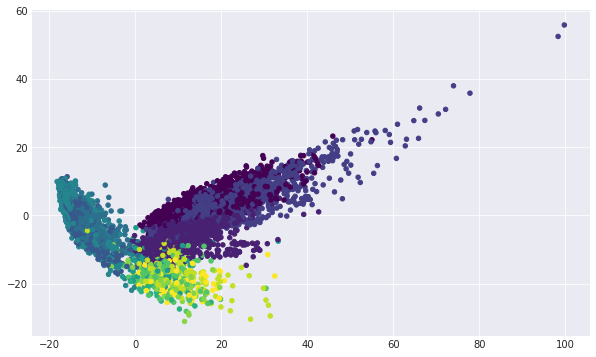

In [11]:
# Showing data from first two columns of X_pca
plt.figure(figsize=(10,6))

plt.scatter(X_pca[:, 0] , X_pca[:, 1] , c=y, s=20, cmap='viridis');

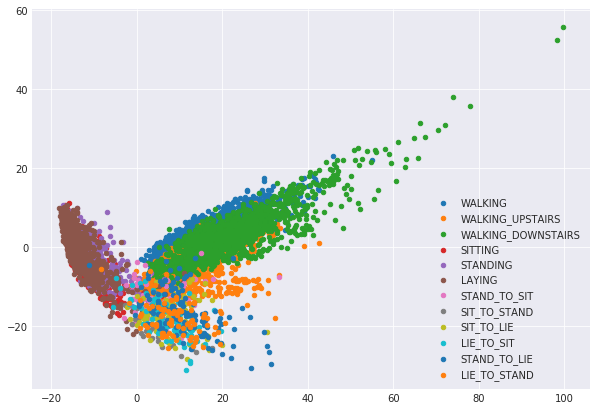

In [12]:
# An experimental section not required by the quesiton!!!
# Create a dictionary to show the legend on graph

x_c = X_pca[:,[0,1]]
labelNames = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING',
              7: 'STAND_TO_SIT', 8: 'SIT_TO_STAND', 9: 'SIT_TO_LIE', 10: 'LIE_TO_SIT', 11: 'STAND_TO_LIE', 12: 'LIE_TO_STAND'}

#plt.figure(figsize=(18,8))

f, ax = plt.subplots()
for i in np.unique(y):
    bool = y == i
    plt.scatter(x_c[bool, 0], x_c[bool, 1], label=labelNames[i], s=20, cmap='Paired')

plt.gcf().set_size_inches((10, 7))        
ax.legend()     
    

**Question 3:**<br>
If everything worked out correctly, you will see a number of clusters, almost perfectly separated from each other. What types of activity are included in these clusters? <br>

**Answer options:**
- 1 cluster: all 12 activities
- 2 clusters: 
- 3 clusters: 
- 5 clusters
- 12 clusters

In [13]:
print("From the figure above, it is not very clear, but I think that there are 3 clusters")
print("The types of activities can be seen from the legend of the above figure, but this was not part of multiple choices")

From the figure above, it is not very clear, but I think that there are 3 clusters
The types of activities can be seen from the legend of the above figure, but this was not part of multiple choices


------------------------------

Run the data clustering using the `KMeans` method, training the model on data with a reduced PCA dimension. In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be searching.

Options:

- ** n_clusters ** = n_classes (number of unique labels of the target class)
- ** n_init ** = 100
- ** random_state ** = RANDOM_STATE (for the reproducibility of the result)

Other parameters should have default values.

In [16]:
# KMeans
kmeans = KMeans(n_clusters=n_classes, random_state=RANDOM_STATE, n_init=100)
kmeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

Visualize the data in the projection on the first two main components. Color the dots according to the clusters received.

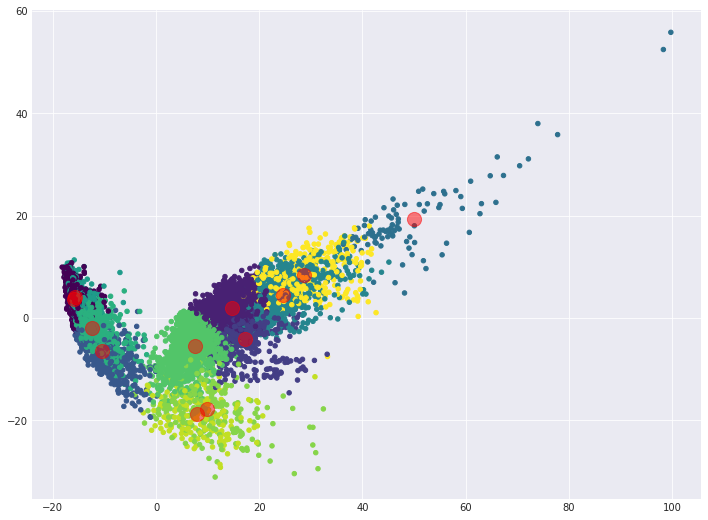

In [18]:
# To plot
cluster_labels= kmeans.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis');

# Experimenting - Not required by the quesiton.
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

Look at the correspondence between the cluster marks and the original class labels and what kinds of activities the `KMeans` algorithm is confused at.

In [20]:
# y is row, cluster_lables is column
tab = pd.crosstab(y, cluster_labels, margins=True)

# Updated based on the descripiton of labels above -- The original list some had typos
tab.index = ['WALKING', 'WALKING_UPSTAIRS',
            'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 
             'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND'  ,'all']

tab.columns = ['cluster' + str(i + 1) for i in range(12)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,all
WALKING,0,903,114,0,11,154,0,0,333,0,0,207,1722
WALKING_UPSTAIRS,0,155,359,0,0,65,0,0,946,0,0,19,1544
WALKING_DOWNSTAIRS,0,351,15,0,81,641,0,0,169,0,0,150,1407
SITTING,64,0,0,228,0,0,1047,456,6,0,0,0,1801
STANDING,0,0,0,62,0,0,953,952,12,0,0,0,1979
LAYING,1485,0,0,364,0,0,48,45,6,3,7,0,1958
STAND_TO_SIT,0,0,4,1,0,0,0,0,28,35,1,1,70
SIT_TO_STAND,0,0,0,3,0,0,0,0,3,14,13,0,33
SIT_TO_LIE,0,0,0,1,0,0,0,0,1,105,0,0,107
LIE_TO_SIT,0,0,0,4,0,0,0,0,1,1,79,0,85


We see that for each class (i.e., each activity) there are several clusters. Let's look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class separates from others when clustering.

Example: if for the class of "WALKING_UPSTAIRS", in which there are 1544 objects, the distribution of clusters is:
 - cluster 1 - 0
 - cluster 2 - 0
 - cluster 3 - 949
 -  ....
 - cluster 12 - 357
 
 then such a share will be 949/1544 $ \ approx $ 0.61.

** Question 4: ** <br>
Which activity has been separated from the rest better than others based on the simple metric described above? <br>

**Answer:**
- 1 WALKING           
- 2 WALKING_UPSTAIRS  
- 3 WALKING_DOWNSTAIRS
- 4 SITTING           
- 5 STANDING          
- 6 LAYING            
- 7 STAND_TO_SIT      
- 8 SIT_TO_STAND      
- 9 SIT_TO_LIE        
- 10 LIE_TO_SIT        
- 11 STAND_TO_LIE      
- 12 LIE_TO_STAND  
- there is no correct answer

In [36]:
actData = tab.iloc[:12,:12].max(axis=1).values / tab.iloc[:12,12].values
actDF=pd.DataFrame({'Activity': tab.index[:12], 'Share': actData})
actDF

m1=actDF['Share'].idxmax() 
#actDF.iloc[m1]
#print("No perfect answers, but it seems Sit-To-Lie has a higher percentage (0.98)")

print("No perfect answers, but it seems activity is ", actDF.iloc[m1][0], " and the percentage is", "{:.2%}".format(actDF.iloc[m1][1]))

,Activity,Share
0,WALKING,0.524390
1,WALKING_UPSTAIRS,0.612694
2,WALKING_DOWNSTAIRS,0.455579
3,SITTING,0.581344
4,STANDING,0.481556
5,LAYING,0.758427
6,STAND_TO_SIT,0.500000
7,SIT_TO_STAND,0.424242
8,SIT_TO_LIE,0.981308
9,LIE_TO_SIT,0.929412


No perfect answers, but it seems activity is  SIT_TO_LIE  and the percentage is 98.13%


Use the elbow method to select the optimal number of clusters. Parameters of the algorithm and the data we use are the same as before, we change only `n_clusters`.

C:\Users\Bita\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


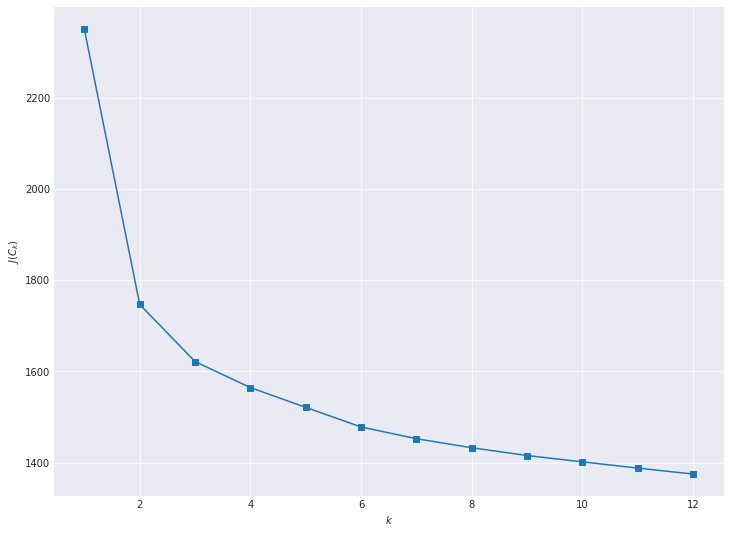

In [37]:
# This is partly based on the code provided in the lecture notes
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans=KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=100).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_)) 

    
plt.plot(range(1, n_classes + 1), inertia, marker='s');
#plt.plot(range(1, 6 + 1), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');      



We calculate $ D(k) $, as described in the lecture

In [38]:
# Check contents of inertia
inertia
len(inertia)

d = {}
for k in range(2, 12):
    inerIndex = k - 1   # Locating the data based on inertiaIndex
    d[k] = (inertia[inerIndex] - inertia[inerIndex + 1]) / (inertia[inerIndex - 1] - inertia[inerIndex])

d.items()

[2350.1666615794015,
 1746.7081000584876,
 1621.5654752156129,
 1564.4463426040722,
 1521.1564826858412,
 1478.1411582065252,
 1452.449319086277,
 1432.534822186604,
 1415.5267018991608,
 1401.5773753128528,
 1387.9804485593475,
 1374.8868117976367]

12

dict_items([(2, 0.20737567220435849), (3, 0.45643227224343164), (4, 0.7578872076479074), (5, 0.9936582044979201), (6, 0.597271773053862), (7, 0.7751292854694058), (8, 0.854057241472296), (9, 0.8201568633428855), (10, 0.9747371437164232), (11, 0.9629850185325964)])

** Question 5: ** <br>
How many clusters can we choose according to the elbow method? <br>

**Answer options:**
- 1
- 2
- 3
- 4
- 5
- 6
- 7 

In [39]:
# The number we choose
print("The graph shows a large decline at 2, also, at 2, d has the smallest number which is 0.20")

The graph shows a large decline at 2, also, at 2, d has the smallest number which is 0.20


------------------------

Let's try another method of clustering, which was described in the article - agglomerative clustering.

In [40]:
ag = AgglomerativeClustering(n_clusters=n_classes,linkage='ward').fit(X_pca)
ag

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=12,
                        pooling_func='deprecated')

In [ ]:
# Just practising with examples to get a better idea of ARI
#labels_t = [0, 0, 0, 1, 1, 1]
#labels_p = [3, 2, 4, 1, 3, 1]
#adjusted_rand_score(labels_t, labels_p)

#labels_t = [0, 0, 0, 1, 1, 1]
#labels_p = [0, 0, 0, 1, 1, 1]
#adjusted_rand_score(labels_t, labels_p)

#labels_t = [0, 0, 0, 1, 1, 1]
#labels_p = [0, 0, 1, 1, 1, 1]
#adjusted_rand_score(labels_t, labels_p)

Calculate the Adjusted Rand Index (`sklearn.metrics`) for the resulting clustering and for ` KMeans` with the parameters from the 4th question.

In [41]:
# ARI for agglomerative
print("For Agglomerative, the ARI is ")
adjusted_rand_score(y,ag.labels_)

For Agglomerative, the ARI is 


0.46574365320501654

In [42]:
# ARI for KMeans from 4th Question
print("For K-Means, the ARI is ")
adjusted_rand_score(y,cluster_labels)

For K-Means, the ARI is 


0.41636325701082716

** Question 6: ** <br>
Select all the correct statements. <br>

** Answer options: **
- ARI expresses the similarity of the tags obtained after clustering, with class labels for the same sample and the higher the value of this index, the better
- According to ARI, KMeans handled clustering worse than Agglomerative Clustering
- For ARI, it does not matter which tags are assigned to the cluster, only the partitioning of objects into clusters is important
- In case of random partitioning into clusters ARI will be close to zero



**Comment:**
Check ARI documentation in sklearn docs

In [44]:
# Answer:
docInfo = "In the docs it is mentioned:\n The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of \n clusters and samples and exactly 1.0 when the clusterings are identical up to a permutation"

print(docInfo)
print("From the notes: This metric does not depend on the labels' values but on the data cluster split.")
print("\nHence: \n")
print("Options 1,3 and 4 seem True")
print("Moreover, KMeans had a lower ARI score than Agglomerative, so Option 2 seems True")

In the docs it is mentioned:
 The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of 
 clusters and samples and exactly 1.0 when the clusterings are identical up to a permutation
From the notes: This metric does not depend on the labels' values but on the data cluster split.

Hence: 

Options 1,3 and 4 seem True
Moreover, KMeans had a lower ARI score than Agglomerative, so Option 2 seems True


In [52]:
# -----------------------------------------------------------------------------------

You can notice that the task is not very well solved just as a clustering task if you select several clusters (> 2). Now, let's solve the classification problem, given that the data is marked up.

For classification, use the support vector machine - class `sklearn.svm.LinearSVC`. in this course, we did not review on this algorithm separately, but it is well-known and you can read about it, for example, in the materials of Yevgeny Sokolov - [here](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Choose the `C` hyperparameter for` LinearSVC` using `GridSearchCV`.

- Train the new `StandardScaler` on the training sample (with all the original features), apply scaling to the test sample
- In `GridSearchCV`, specify cv = 3.

In [45]:
# Scaling test and train data seperately
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
# Linear Support Vector Classification
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [47]:
# Cross Validation of SVC with CV=3
best_svc = GridSearchCV(svc, svc_params, cv=3, verbose=1)
best_svc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Bita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to 

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [48]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9284150894811382)

**Question 7**<br>
Which value of the hyperparameter `C` was chosen the best on the basis of cross-validation? <br>

**Answer options:**
- 0.001
- 0.01
- 0.1,
- 1
- 10

In [49]:
print("The best value of C is ", best_svc.best_params_['C'])

The best value of C is  0.1


In [59]:
# ---------------------------------------------------------------------

In [50]:
y_predicted = best_svc.predict(X_test_scaled)

In [51]:
# y_test is row, y_predicted is column
tab = pd.crosstab(y_test, y_predicted, margins=True)

# The following are fixed from Typos

tab.index = ['WALKING', 'WALKING_UPSTAIRS',
            'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 
             'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND'  ,'all']

tab.columns = ['WALKING', 'WALKING_UPSTAIRS',
            'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 
             'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND'  ,'all']
tab



,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,STAND_TO_SIT,SIT_TO_STAND,SIT_TO_LIE,LIE_TO_SIT,STAND_TO_LIE,LIE_TO_STAND,all
WALKING,495,1,0,0,0,0,0,0,0,0,0,0,496
WALKING_UPSTAIRS,17,450,1,1,0,0,1,0,0,0,1,0,471
WALKING_DOWNSTAIRS,4,3,411,0,2,0,0,0,0,0,0,0,420
SITTING,0,4,0,439,62,2,1,0,0,0,0,0,508
STANDING,0,0,0,12,543,0,1,0,0,0,0,0,556
LAYING,0,0,0,0,8,537,0,0,0,0,0,0,545
STAND_TO_SIT,0,0,0,1,2,0,19,0,1,0,0,0,23
SIT_TO_STAND,0,0,0,0,0,0,0,10,0,0,0,0,10
SIT_TO_LIE,0,0,0,0,2,1,2,0,21,0,6,0,32
LIE_TO_SIT,0,0,0,0,0,0,0,0,0,18,0,7,25


As you can see, the classification problem is solved quite well.

** Question 8: ** <br>
Does SVM confuse the classes inside the activity groups we identified earlier (in the question 3)? We consider that it is confused, if the algorithm was wrong at least in one case. <br>

**Answer options:**
- yes
- no


In [52]:
print("The answer is yes, it does confuse classes inside activity groups")
#print("As can be seen from the above table, there are cases where the algorithm was wrong")
print("For example, one instance of walking is identified as walking upstairs")

The answer is yes, it does confuse classes inside activity groups
For example, one instance of walking is identified as walking upstairs


Finally, do the same thing as in Question 7, but add the PCA.

- Use the samples `X_train_scaled` and` X_test_scaled
- Teach the same PCA as before, on a scaled training sample, apply the conversion to a test
- Choose the hyperparameter `C` with cross-validation on the training sample with PCA-transformation. You will notice how much faster it works than before.


** Question 9: ** <br>
What is the difference between the best quality (the proportion of correct answers) for cross-validation in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent. <br>

** Options: **
- The quality is the same
- 2%
- 4%
- 10%
- 20%

In [53]:
# First scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Applying PCA
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_P = pca.fit_transform(X_train_scaled)
X_test_P = pca.transform(X_test_scaled)


# preparing for Grid Search
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}


# performing Grid Search - Support Vector Machines
pca_best_svc = GridSearchCV(svc, svc_params, cv=3, verbose=1)

# Fitting the training data
pca_best_svc.fit(X_train_P, y_train)

# Get the best parameters
pca_best_svc.best_params_, pca_best_svc.best_score_
print("The best value of C is ", pca_best_svc.best_params_['C'])


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Bita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to 

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

({'C': 0.1}, 0.8843826445216943)

The best value of C is  0.1


In [54]:
print("The best score returned without PCA is", best_svc.best_score_)
print("The best score by using PCA is", pca_best_svc.best_score_)

print("The difference is {:.0%}".format(best_svc.best_score_ - pca_best_svc.best_score_))
print("")

The best score returned without PCA is 0.9284150894811382
The best score by using PCA is 0.8843826445216943
The difference is 4%



** Question 10: ** <br>
Select all the correct statements:

** Answer options: **
- Principal component analysis in this case allowed to reduce the model training time, while the quality (the proportion of correct responses on cross-validation) suffered greatly, by more than 10%
- PCA can be used to visualize data, but there are better methods for this task, for example, tSNE. But PCA has less computational complexity
- PCA builds linear combinations of initial characteristics that are poorly interpreted by humans
- SVM works better than kMeans, since it clearly reduces the algorithm to the optimization problem

In [55]:
# The answer
print("Option 1 is incorrect due to the fact that the quality loss was 4% and not 10% - However, PCA helped with training time")
print("")
print("Option 4 seems incorrect, as KMeans is typically used for unsupervised learning and SVM for supervised learning, and perhaps they should not be compared")
print("However, there seem to be variations of SVM like Support Vector Clustering https://dl.acm.org/doi/10.5555/944790.944807")
print("Or Supervised KMeans like http://www.cs.cornell.edu/~tomf/publications/supervised_kmeans-08.pdf")
print("So it would be interesting to learn about them and compare the differences")
print("")
print("Option 2 seems correct as mentioned in the notes: with tSNE, the picture looks better since PCA has a linear constraint while t-SNE does not.")
print("However, even with such a small dataset, the t-SNE algorithm takes significantly more time to complete than PCA ")
print("")
print("Option 3 seems correct, as sometimes the chosen features along with their percentages may not be clear.")
      

Option 1 is incorrect due to the fact that the quality loss was 4% and not 10% - However, PCA helped with training time

Option 4 seems incorrect, as KMeans is typically used for unsupervised learning and SVM for supervised learning, and perhaps they should not be compared
However, there seem to be variations of SVM like Support Vector Clustering https://dl.acm.org/doi/10.5555/944790.944807
Or Supervised KMeans like http://www.cs.cornell.edu/~tomf/publications/supervised_kmeans-08.pdf
So it would be interesting to learn about them and compare the differences

Option 2 seems correct as mentioned in the notes: with tSNE, the picture looks better since PCA has a linear constraint while t-SNE does not.
However, even with such a small dataset, the t-SNE algorithm takes significantly more time to complete than PCA 

Option 3 seems correct, as sometimes the chosen features along with their percentages may not be clear.
